Sort people into leagues for curling
KL 8/17/2016; update 8/30/2016; update 9/15/2016; update 12/23/2016; update 9/2017

KL 12/20/2017: Adding new leagues and skipping league manager placement while testing; 9/18/2019 updating for new season

This version randomizes the people first

In [1001]:
# Before running this:
#     (1) decide on max # of leagues and change that in the input.csv file,
#     (2) decide on nLimit for each league
#     (3) might need to optimize people's priority lists to increase number getting into 4 pm
#     (4) update the list of league managers

In [1002]:
#the -f does this without user confirmations
%reset -f

In [1003]:
setSeed = True

In [1004]:
#set the random seed...if a number...will be able to recreate the random numbers
if setSeed == True:
    SEED = 42
elif setSeed == False:
    SEED = None

In [1005]:
import pandas as pd
import numpy as np
import math
import csv
import os
from datetime import datetime

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 

%matplotlib inline

Define some functions up top

In [1006]:
#add the league manager to a league. They will be first on the list.
def addManager(leagueDictionary,r,manager): #here r is the index in...
    useRow = r.index[0]
    #oneName = regSorted.loc[useRow,['lastname', 'firstname']] 
    oneName = regSorted.loc[useRow,['Last Name', 'First Name', 'Email']] 
    oneName = oneName.to_frame().transpose() #need this format to make nice output
    #leagueDictionary[manager] = oneName #used to work, but now has , at end of tuple
    #get rid of the @#$#% comma, updated 9/22/2019
    forIdx = ''.join(manager)
    leagueDictionary[forIdx] = oneName   
    regSorted.loc[useRow,forIdx]=np.nan
    regTracking.loc[useRow,forIdx]='yes'
    return leagueDictionary

In [1007]:
#this adds a person to an 'open' league - or one where they have had to decide on priorities
def addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues):
    #person is interested in open leagues, oneLeague will be index in their next choice
    #prior to Fall 2019, this worked, seems to be a new format in the Excel file
    #oneLeague = regSorted.loc[idx,openLeagues].dropna().idxmin()
    #probably a better way to do this, but gather up all the bits in one line (yikes!)
    oneLeague = pd.to_numeric(regSorted.loc[idx,openLeagues].dropna()).idxmin()
    
    oneName = regSorted.loc[idx,['Last Name', 'First Name', 'Email']]
    oneName = oneName.to_frame().transpose() #need this format to make nice output

    if len(leagueDict_open[oneLeague]) < (nLimit.loc[oneLeague,'nLimit']): #room in league
        leagueDict_open = addOne(leagueDict_open,oneLeague,oneName)
        #now that I have added the person to a league, change their priority to NaN
        regSorted.loc[idx,oneLeague] = np.nan
        regTracking.loc[idx,oneLeague] = 'yes'

    elif len(leagueDict_open[oneLeague]) == (nLimit.loc[oneLeague,'nLimit']):
        #league is full...does this person have another league listed?
        #first, set current to NaN
        regSorted.loc[idx,oneLeague] = np.nan
        regTracking.loc[idx,oneLeague] = 'no' #did not get in
        nextPriority = regSorted.loc[idx,openLeagues].dropna().min()
        if math.isnan(nextPriority)!=1: #have a number
            #go to the next league on their list
            nextLeague = pd.to_numeric(regSorted.loc[idx,openLeagues].dropna()).idxmin()
            
            #only add person is league has space
            if len(leagueDict_open[nextLeague]) < (nLimit.loc[nextLeague,'nLimit']):
                leagueDict_open = addOne(leagueDict_open,nextLeague,oneName)
                regSorted.loc[idx,nextLeague] = np.nan
                regTracking.loc[idx,nextLeague] = 'yes'
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==1):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInFirst',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==2):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInSecond',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==3):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInThird',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==4):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInFourth',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==5):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInFifth',oneName)
        elif math.isnan(nextPriority)==1:
            trackIssues=addOne(trackIssues,'noAdditionalChoice',oneName)
                           
    return regSorted, regTracking, leagueDict_open, trackIssues

In [1008]:
#this adds a person to a league without worrying about priorities (e.g., Mens or Ladies league)
def addOne(leagueDict,oneLeague,oneName):
    if len(leagueDict[oneLeague])==0: #nothing there yet
        leagueDict[oneLeague] = oneName
    else:     #need to append
        leagueDict[oneLeague] = leagueDict[oneLeague].append(oneName)
    return leagueDict

Read in the data

In [1009]:
#New behind the scenes program exports an Excel file...
fName = 'registrants_list_on_2019-09-18.KLworking.xlsx' 
importInfo = pd.read_excel(io=fName)

#Men's league has an apostrophe that causes issues, rename it here
importInfo.rename(
  columns={"Men's League": 'Mens League'},inplace=True)

In [1010]:
#shuffle the information from the website site to match the format in the rest of this file
openLeagues = ['Sunday Night', 'Monday 4PM', 'Monday Night','Tuesday 10AM','Tuesday 4PM',
               'Wednesday 4PM','Thursday 4PM'] #updated to match the priority list
otherLeagues = ['Mens League', 'Ladies League' ,'Scrod League']

priorities = ['First Open League Choice','Second Open League Choice',
              'Third Open League Choice','Fourth Open League Choice',
              'Fifth Open League Choice','Sixth Open League Choice']

regInfo = importInfo.loc[:,(['First Name','Last Name','Email',
                             'How many Chamionship Leagues would you like to play in?'] + otherLeagues)]

#hack to shift to old name bc old name has no spaces!
regInfo.rename(columns={'How many Chamionship Leagues would you like to play in?': 'League_Number_Open'}, inplace=True) 

for item in openLeagues:
    #add columns with open league names and fill with NaN
    regInfo[item] = np.nan

In [1011]:
nPeople = len(regInfo.index)
for idx in range(0,nPeople):
    for idxP in enumerate(priorities):
        #remember: enumerate will allow idxP[0] is the number, while idxP[1] is the value
        getOne = importInfo.loc[idx,idxP[1]]
        if isinstance(getOne,str): #updated 9/22/2019
            regInfo.loc[idx,getOne] = idxP[0] + 1  #want 1,2,3 and not python zero index

In [1012]:
#regInfo.loc[importInfo['Last Name']=="O'Connor"] #use this to find one person's registration
regInfo.loc[importInfo['Last Name']=="Adams"]

,First Name,Last Name,Email,League_Number_Open,Mens League,Ladies League,Scrod League,Sunday Night,Monday 4PM,Monday Night,Tuesday 10AM,Tuesday 4PM,Wednesday 4PM,Thursday 4PM
1,Nathan,Adams,adams.nathan.t@gmail.com,1.0,No,No,No,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Tom,Adams,tradams121@gmail.com,1.0,No,No,No,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [1013]:
#first, how many random numbers so I need?
nPeople = len(regInfo.index)
np.random.seed(SEED)
regInfo['randomNumCol'] = np.random.choice(range(nPeople), nPeople,replace = False)

##put in place to rank people higher if they only want to curl in one championship league
if False:
    for idx in (range(0,nPeople)):
        if regInfo.loc[idx,'League_Number_Open'] != '1':
            regInfo.loc[idx,'randomNumCol'] = regInfo.loc[idx,'randomNumCol'] + 1000

In [1014]:
##so now, moving back to the list of people, sort the list by the random number
regSorted = regInfo.sort_values(by = 'randomNumCol', ascending=True)
regSorted.reset_index(inplace = True)
#copy so I can have an output tracking what was done, make after I put in league managers
regTracking = regSorted.copy(deep=True)

In [1015]:
issueNames = ['notInFirst','notInSecond','notInThird','notInFourth','notInFifth','noAdditionalChoice']
#setup the dictionary to hold the issues
trackIssues = {}
for name in issueNames:
    trackIssues[name] = pd.DataFrame()

In [1016]:
#setup the dictionary to hold the people information (start with openLeagues only)
forDictionary = openLeagues
#forDictionary.extend(otherLeagues)
leagueDict_open = {}
for name in forDictionary:
    leagueDict_open[name] = pd.DataFrame()

In [1017]:
#set the limit for each league (can set to big numbers to see how oversubscribed each league is)
fiveTeams = 20
sixTeams = 24
sevenTeams = 28 
eightTeams = 32
elevenTeams = 44
fourteenTeams = 56

d = {'Sunday Night': eightTeams,
     'Monday 4PM': sevenTeams,
     'Monday Night': fourteenTeams,
     'Tuesday 10AM': sevenTeams,
     'Tuesday 4PM': sixTeams,
     'Wednesday 4PM': sevenTeams,
     'Thursday 4PM': sevenTeams,}

nLimit = pd.DataFrame({'nLimit' : d})
del d

In [1018]:
# put the manager information into a loop bc need to check later for them
# this cell usually fails if I have the league managers names wrong...
##place holders in here
names = [['Nathan','Adams'],['Jeanie','Yaroch'],['George', 'Bagley'],
         ['Mary' ,'Colacchio'],['James', 'Woodworth'], #placeholder
        ['Katie', 'Murphy'],['Bill', 'Gallagher']] #placeholder

leagues = ['Sunday Night','Monday 4PM','Monday Night','Tuesday 10AM','Tuesday 4PM',
           'Wednesday 4PM','Thursday 4PM']
managers = pd.DataFrame(names,columns = ['firstname','lastname'],index = [leagues])
#del names,leagues

if True:
    #put the league managers into their league and set their the choice for that league to NaN
    for oL,item in managers.iterrows():
        #print(oL,item)
        r = regSorted.loc[(regSorted['Last Name']==item.lastname) & (regSorted['First Name']==item.firstname)]
        #print(r)
        leagueDict_open = addManager(leagueDict_open,r,oL)  

In [1019]:
leagueDict_open

{'Sunday Night':    Last Name First Name                     Email
 15     Adams     Nathan  adams.nathan.t@gmail.com,
 'Monday 4PM':    Last Name First Name                     Email
 92    Yaroch     Jeanie  jeanieyaroch@comcast.net,
 'Monday Night':    Last Name First Name               Email
 30    Bagley     George  gnbagley@gmail.com,
 'Tuesday 10AM':     Last Name First Name                      Email
 86  Colacchio       Mary  marycolacchio@verizon.net,
 'Tuesday 4PM':     Last Name First Name                  Email
 14  Woodworth      James  jwoodworthstl@aol.com,
 'Wednesday 4PM':     Last Name First Name              Email
 187    Murphy      Katie  quissettk@aol.com,
 'Thursday 4PM':      Last Name First Name                     Email
 177  Gallagher       Bill  b.gallagher.ma@gmail.com}

In [1020]:
managers

,firstname,lastname
Sunday Night,Nathan,Adams
Monday 4PM,Jeanie,Yaroch
Monday Night,George,Bagley
Tuesday 10AM,Mary,Colacchio
Tuesday 4PM,James,Woodworth
Wednesday 4PM,Katie,Murphy
Thursday 4PM,Bill,Gallagher


In [1021]:
nPeople

208

In [1022]:
if np.isnan(regTracking.loc[3,'League_Number_Open']) == True:
    print('test')

In [1023]:
regTracking.loc[3,'League_Number_Open'] == np.isnan

False

The actual sorting process starts in the following cell

In [1024]:
iteration = 1
for idx in (range(0,(nPeople-1))):
    #if regTracking.loc[idx,'League_Number_Open'] != 'nan':
    if np.isnan(regTracking.loc[idx,'League_Number_Open']) == False:
        #Tracer()()
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
    
if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)


In [1025]:
#now go backwards through the list to fill the other spots
iteration = 2
for idx in (range((nPeople - 1),0,-1)):
    #ignore person who does not want open leagues:
    if np.isnan(regTracking.loc[idx,'League_Number_Open']) == False:
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)

In [1026]:
trackIssues

{'notInFirst': Empty DataFrame
 Columns: []
 Index: [], 'notInSecond': Empty DataFrame
 Columns: []
 Index: [], 'notInThird': Empty DataFrame
 Columns: []
 Index: [], 'notInFourth': Empty DataFrame
 Columns: []
 Index: [], 'notInFifth': Empty DataFrame
 Columns: []
 Index: [], 'noAdditionalChoice': Empty DataFrame
 Columns: []
 Index: []}

In [1027]:
#go forwards again
iteration = 3
for idx in (range(0,(nPeople-1))):
    #ignore person who does not want open leagues:
    if np.isnan(regTracking.loc[idx,'League_Number_Open']) == False:
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)

In [1028]:
trackIssues

{'notInFirst': Empty DataFrame
 Columns: []
 Index: [], 'notInSecond': Empty DataFrame
 Columns: []
 Index: [], 'notInThird': Empty DataFrame
 Columns: []
 Index: [], 'notInFourth': Empty DataFrame
 Columns: []
 Index: [], 'notInFifth': Empty DataFrame
 Columns: []
 Index: [], 'noAdditionalChoice':      Last Name First Name                        Email
 122       Mili      Peter           pdotmili@gmail.com
 129    Trainor      Sandy     sandytrainor70@gmail.com
 144    Perella       Anne  Perellafalmouth@comcast.net
 177  Gallagher       Bill     b.gallagher.ma@gmail.com
 200    Trainor     Daniel      dtrainor115@comcast.net}

In [1029]:
##add a fourth iteration...there might be space
#now go backwards through the list to fill the other spots
iteration = 4
for idx in (range((nPeople-1),0,-1)):
    #ignore person who does not want open leagues:
    if np.isnan(regTracking.loc[idx,'League_Number_Open']) == False:
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)        

In [1030]:
otherLeagues

['Mens League', 'Ladies League', 'Scrod League']

In [1031]:
#make a new dictionary for other leagues...concat with openLeagues when done
# do doubles and competitive league by hand...
#already defined this above...
#otherLeagues = ['League_4_Men', 'League_7_Ladies' ,'League_Scrod']

leagueDict_other = {}
for name in otherLeagues:
    leagueDict_other[name] = pd.DataFrame()

In [1032]:
#only have to go through once
for idx, item in regTracking.iterrows():
    for oL in otherLeagues:
    
        oneName = regSorted.loc[idx,['Last Name', 'First Name','Email']] #updated 9/13/2018
        oneName = oneName.to_frame().transpose() #need this format to make nice output
        if regSorted.loc[idx,oL]=='Yes': #careful with trailing spaces
            leagueDict_other = addOne(leagueDict_other,oL,oneName)
            #now that I have added the person to a league, change their priority to NaN
            regTracking.loc[idx,oL] = 'done'
            regSorted.loc[idx,oL] = np.nan

In [1033]:
#combine the two dictionaries
leagueDict_all = leagueDict_open.copy()
leagueDict_all.update(leagueDict_other)

#combine the list of names
allLeagues = list(openLeagues)
allLeagues.extend(otherLeagues)

In [1034]:
#finally, export the results, until I have everyone...no need to keep every iteration
folder = 'result_working' 
if not os.path.exists(folder):
    os.makedirs(folder)    

In [1035]:
allLeagues

['Sunday Night',
 'Monday 4PM',
 'Monday Night',
 'Tuesday 10AM',
 'Tuesday 4PM',
 'Wednesday 4PM',
 'Thursday 4PM',
 'Mens League',
 'Ladies League',
 'Scrod League']

In [1036]:
#change this to sort alphabetically before exporting
for fn in allLeagues:
    fName = '%s.csv' % fn
    #new folder for each run...
    tData = leagueDict_all[fn].sort_values(by = ['Last Name'])
    tData.to_csv(folder + '/' + fName)

can ran multiple times and saved the output

In [1037]:
#count up number of issues
for problem in issueNames:
    print(problem, ': ', len(trackIssues[problem]), ' people in this category')

notInFirst :  0  people in this category
notInSecond :  0  people in this category
notInThird :  0  people in this category
notInFourth :  1  people in this category
notInFifth :  0  people in this category
noAdditionalChoice :  7  people in this category


,nPeople
Mens League,32.0
Ladies League,28.0
Scrod League,24.0


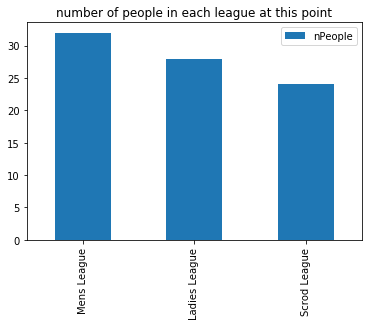

In [1038]:
#do some plotting...visually see how people distributed
gather = pd.DataFrame(np.nan, index = otherLeagues, columns=['nPeople'])
for name in otherLeagues:
    gather.loc[name,'nPeople'] = len(leagueDict_all[name])
    
gather.plot(kind = 'bar',title='number of people in each league at this point')
gather

,nPeople
Sunday Night,32.0
Monday 4PM,28.0
Monday Night,44.0
Tuesday 10AM,28.0
Tuesday 4PM,23.0
Wednesday 4PM,25.0
Thursday 4PM,28.0


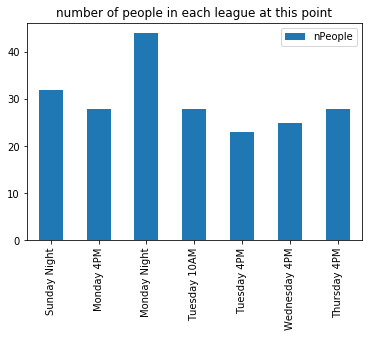

In [1039]:
#do some plotting...visually see how people distributed
gather = pd.DataFrame(np.nan, index = openLeagues, columns=['nPeople'])
for name in openLeagues:
    gather.loc[name,'nPeople'] = len(leagueDict_open[name])
    
gather.plot(kind = 'bar',title='number of people in each league at this point')
gather

In [1040]:
#gather up the number of people with # 'yes' < League_Number_Open
outcome = regTracking.copy(deep = True)

for idx, item in regTracking.iterrows():
    #if regTracking.loc[idx,'League_Number_Open'] != 'None':
    if np.isnan(regTracking.loc[idx,'League_Number_Open']) == False:
        r = regTracking.loc[idx,openLeagues]
        nLeagues = 0
        for item in range(0,len(r)):
            if r[item] == 'yes':
                nLeagues = nLeagues + 1
        if nLeagues == int(regTracking.loc[idx,'League_Number_Open']):
            #delete from the dataframe
            outcome.drop(idx,inplace = True)
    else: #did not want open leagues, drop them too
        outcome.drop(idx,inplace = True)
        
outcome.sort_values(by = 'League_Number_Open', inplace = True)

In [1046]:
#this will be the list of people who did not get everything they wanted 
#(in terms of the # of 'championship' leagues)
#outcome

In [1042]:
len(outcome)

9

In [1043]:
#alphabetize regTracking before saving
regTracking.sort_values(by = 'Last Name',inplace = True)

outcome.to_csv(folder + '/exportOutcome.csv')
regTracking.to_csv(folder + '/exportTracking.csv')
regSorted.to_csv(folder + '/exportSorted.csv')
regInfo.to_csv(folder + '/exportInfo.csv')

In [1044]:
#can run multiple times and see what the best possible outcome is...would want to keep that...

In [1045]:
for problem in issueNames:
    print(problem, ': ', len(trackIssues[problem]), ' people in this category')

notInFirst :  0  people in this category
notInSecond :  0  people in this category
notInThird :  0  people in this category
notInFourth :  1  people in this category
notInFifth :  0  people in this category
noAdditionalChoice :  7  people in this category
